Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import zipfile
from google.colab import drive
from glob import glob
import time

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [2]:
# #Mount Google Drive
# drive.mount('/content/drive')

# # Path to the zip file in Google Drive
# zip_path = "/content/drive/My Drive/Upgrad_Files/CNN_Assignment/CNN_assignment.zip"

# # Extract the zip file
# extract_path = "/content/melanoma_dataset"
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print("Dataset extracted to:", extract_path)

Mounted at /content/drive
Dataset extracted to: /content/melanoma_dataset


In [5]:
# # Path to the Data Folder
extract_path = "data"

Just for Analysis on the Total Execution Time we are recording the start and end time of the notebook's run

In [3]:
# Record the execution start time
start_time = time.time()

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(extract_path, "Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path(extract_path, "Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.



---


We are creating the Train Dataset here with tf.keras.preprocessing.image_dataset_from_directory function.

We set the parameter as seed=123.

We are also resizing the images to the size defined before.

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.




---


We are creating the Validation Dataset here with tf.keras.preprocessing.image_dataset_from_directory function.

We set the parameter as seed=123.

We are also resizing the images to the size defined before.

In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


Print All the class names in the train dataset

In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

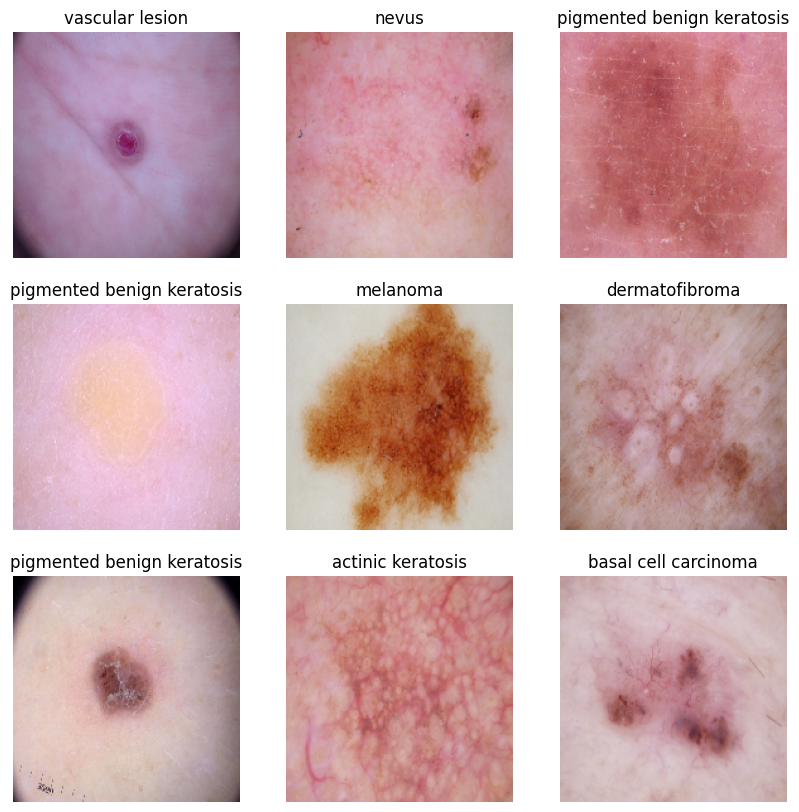

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(len(class_names)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
# Normalize pixel values
normalization_layer = layers.Rescaling(1./255)
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = normalized_train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = normalized_val_ds.prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the model
Here we choose the "adam" optimiser and "SparseCategoricalCrossentropy" loss function for model training

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 268ms/step - accuracy: 0.2233 - loss: 2.1053 - val_accuracy: 0.3915 - val_loss: 1.7623
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 250ms/step - accuracy: 0.3752 - loss: 1.7143 - val_accuracy: 0.4586 - val_loss: 1.6111
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 245ms/step - accuracy: 0.4566 - loss: 1.5240 - val_accuracy: 0.4787 - val_loss: 1.5266
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 243ms/step - accuracy: 0.5026 - loss: 1.4187 - val_accuracy: 0.5257 - val_loss: 1.3835
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 245ms/step - accuracy: 0.5646 - loss: 1.2626 - val_accuracy: 0.4989 - val_loss: 1.4007
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 241ms/step - accuracy: 0.5693 - loss: 1.2095 - val_accuracy: 0.5190 - val_loss: 1.4348
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 244ms/step - accuracy: 0.6005 - loss: 1.1486 - val_accuracy: 0.4765 - val_loss: 1.5553
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 244ms/step - accuracy: 0.5731 - loss: 1.1887 - val_accuracy: 0.528

### Visualizing training results

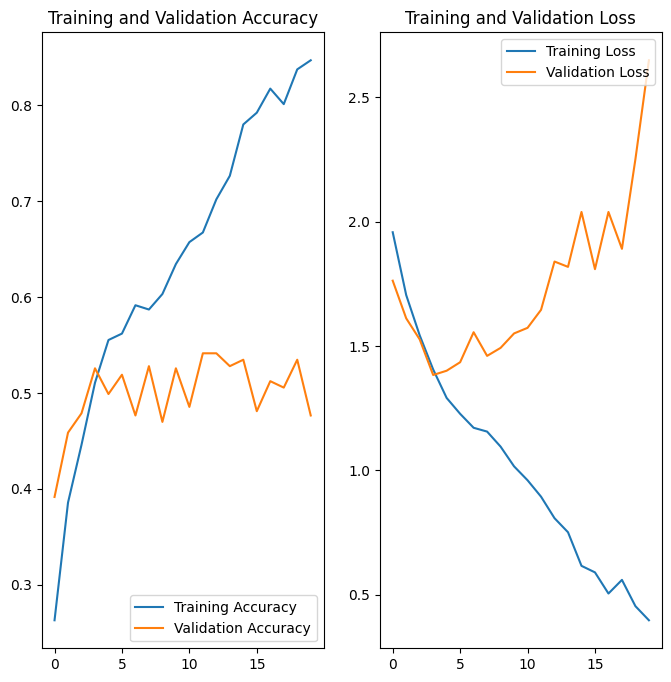

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### After analyzing the plots of training and validation accuracy/loss:
##### - The training accuracy is significantly higher than the validation accuracy and the validation loss increases after some epochs, it indicates overfitting.
##### - Training metrics are improving while validation metrics worsen, showing the model isn't generalizing well.

### Write your findings here

To deal with the overfitting, we apply data augmentation strategy

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2)
])

Visualize how your augmentation strategy works for one instance of training image.

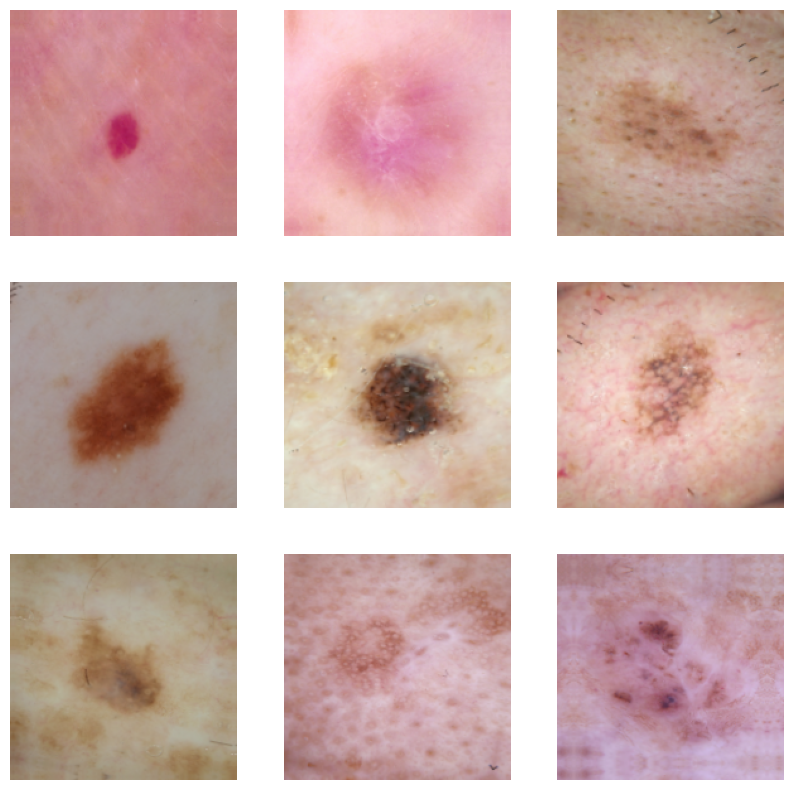

In [25]:


for images, _ in train_ds.take(1):
    augmented_images = data_augmentation(images)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy())
        plt.axis("off")


### Retrain the Model after augmentation
### Create the model, compile and train the model


In [26]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model_augmented = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])


### Compiling the model

In [27]:
model_augmented.compile(optimizer='adam',
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy'])

### Training the model

In [28]:
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

epochs_augmented = 20
history = model_augmented.fit(
  augmented_train_ds,
  validation_data=val_ds,
  epochs=epochs_augmented
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 405ms/step - accuracy: 0.2289 - loss: 2.1066 - val_accuracy: 0.3960 - val_loss: 1.7464
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 441ms/step - accuracy: 0.4077 - loss: 1.6791 - val_accuracy: 0.3736 - val_loss: 1.6907
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 441ms/step - accuracy: 0.3848 - loss: 1.7109 - val_accuracy: 0.4676 - val_loss: 1.5800
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 465ms/step - accuracy: 0.4320 - loss: 1.5826 - val_accuracy: 0.4072 - val_loss: 1.6367
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 504ms/step - accuracy: 0.4356 - loss: 1.5820 - val_accuracy: 0.4743 - val_loss: 1.5060
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 415ms/step - accuracy: 0.4967 - loss: 1.4440 - val_accuracy: 0.4787 - val_loss: 1.4505
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 444ms/step - accuracy: 0.4999 - loss: 1.3719 - val_accuracy: 0.4430 - val_loss: 1.6658
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 450ms/step - accuracy: 0.4938 - loss: 1.4610 - val_accu

### Visualizing the results

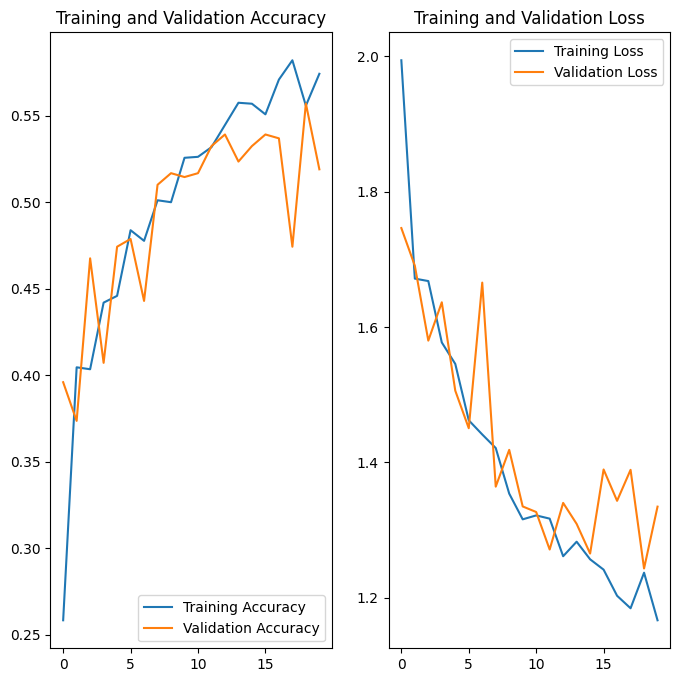

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### - The model now shows a Good balanced fitting.
##### - Training and validation metrics stay close together and improve steadily, indicating good generalization.

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [30]:
# First, check class distribution
for class_name in class_names:
    class_dir = pathlib.Path(data_dir_train/class_name)
    count = len(list(class_dir.glob('*.jpg')))
    print(f"{class_name}: {count} images")

actinic keratosis: 114 images
basal cell carcinoma: 376 images
dermatofibroma: 95 images
melanoma: 438 images
nevus: 357 images
pigmented benign keratosis: 462 images
seborrheic keratosis: 77 images
squamous cell carcinoma: 181 images
vascular lesion: 139 images


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### Answer -
1. The class with the least number of samples is seborrheic keratosis with 77 images.

2. The classes that dominate the data in terms of proportionate number of samples are:
Pigmented benign keratosis (20.63%),
Melanoma (19.58%),
Basal cell carcinoma (16.80%),
Nevus (15.96%).

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [31]:
!pip install Augmentor

Storing the Original Data to a DataFrame

In [32]:
original_image_paths = glob(os.path.join(data_dir_train, '*', '*.jpg'))
original_labels = [path.split('/')[-2] for path in original_image_paths]

original_df = pd.DataFrame({'image_path': original_image_paths, 'label': original_labels})

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [33]:
path_to_training_dataset=str(data_dir_train)
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(pathlib.Path(path_to_training_dataset, i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x782E4E297430>: 100%|██████████| 500/500 [00:20<00:00, 24.15 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x782E4E2CB250>: 100%|██████████| 500/500 [00:19<00:00, 25.08 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x782E4E3A4D90>: 100%|██████████| 500/500 [00:17<00:00, 28.09 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x782E4E10D030>: 100%|██████████| 500/500 [01:22<00:00,  6.08 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=824x719 at 0x782E4E295DE0>: 100%|██████████| 500/500 [01:07<00:00,  7.36 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x782E4E243C40>: 100%|██████████| 500/500 [00:16<00:00, 30.08 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x782E4E10F460>: 100%|██████████| 500/500 [00:38<00:00, 13.03 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x782E4E241D20>: 100%|██████████| 500/500 [00:14<00:00, 34.04 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x782E4E10F430>: 100%|██████████| 500/500 [00:14<00:00, 33.49 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [34]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [36]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027135.jpg_a0da7e61-589f-4fa5-b403-af1d2e5b426c.jpg',
 '/content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030813.jpg_22fb247c-84b6-4c76-9367-c25118d02d90.jpg',
 '/content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031513.jpg_dc972428-7faa-4e5d-811e-3517fd30896e.jpg',
 '/content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029352.jpg_b22ad2a0-cf23-4402-8f6f-9764eccf2c47.jpg',
 '/content/melanoma_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma

In [37]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [38]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [39]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2])

In [40]:
new_df['Label'].value_counts()

,count
Label,
basal cell carcinoma,500
vascular lesion,500
pigmented benign keratosis,500
seborrheic keratosis,500
nevus,500
actinic keratosis,500
squamous cell carcinoma,500
dermatofibroma,500
melanoma,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [41]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [42]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [43]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [45]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),

    # First Conv Block
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Second Conv Block
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    # Third Conv Block
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

# Adding Callback to Retain the val_loss
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        min_delta=0.001
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [53]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

#### **Todo:**  Train your model

In [54]:
# Train with callbacks
epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 259ms/step - accuracy: 0.2521 - loss: 2.5812 - val_accuracy: 0.0831 - val_loss: 4.2992 - learning_rate: 3.0000e-04
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 84s 272ms/step - accuracy: 0.3396 - loss: 2.0642 - val_accuracy: 0.1084 - val_loss: 13.0368 - learning_rate: 3.0000e-04
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 83s 278ms/step - accuracy: 0.3690 - loss: 1.9231 - val_accuracy: 0.1700 - val_loss: 15.2969 - learning_rate: 3.0000e-04
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 76s 242ms/step - accuracy: 0.3833 - loss: 1.7758 - val_accuracy: 0.3927 - val_loss: 2.2852 - learning_rate: 3.0000e-04
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 238ms/step - accuracy: 0.3822 - loss: 1.7203 - val_accuracy: 0.3831 - val_loss: 2.2114 - learning_rate: 3.0000e-04
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 243ms/step - accuracy: 0.4155 - loss: 1.6638 - val_accuracy: 0.4662 - val_loss: 1.5467 - learning_rate: 3.0000e-04
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 46s 

#### **Todo:**  Visualize the model results

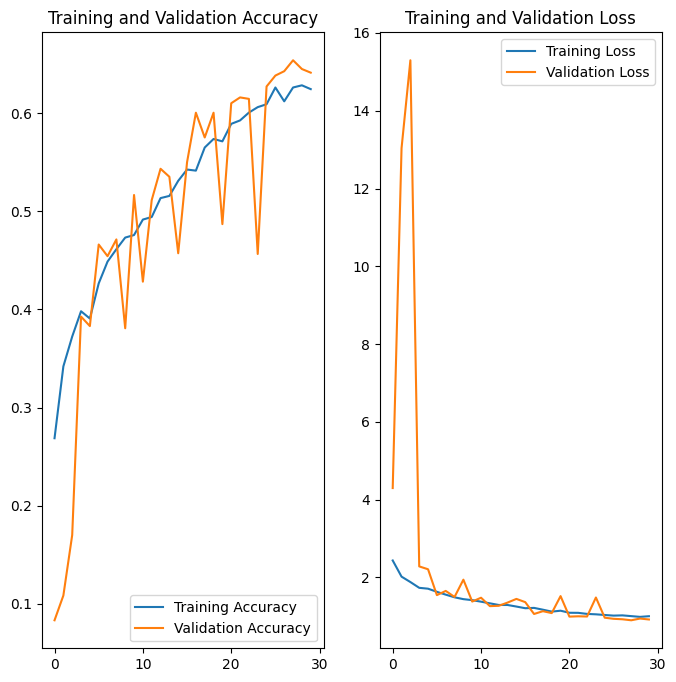

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Based on the improved performance and better generalization in Model 3, it appears class rebalancing helped achieve:


- More stable training
- Better generalization
- Higher overall accuracy while avoiding overfitting
- More balanced performance between classes (indicated by higher validation accuracy)



In [56]:
# Record the end time
end_time = time.time()
# Calculate the total execution time
execution_time_minutes = (end_time - start_time) / 60
print(f"Start time: {start_time}")
print(f"End time: {end_time}")
print(f"Total execution time: {execution_time_minutes:.2f} minutes")

Start time: 1736859850.3668828
End time: 1736863543.059749
Total execution time: 61.54 minutes
